# Analysis of Physical Oceanographic Data - SIO 221A
### Python version of [Sarah Gille's](http://pordlabs.ucsd.edu/sgille/sioc221a/index.html) notes by:
#### Bia Villas Bôas (avillasboas@ucsd.edu) & Gui Castelão (castelao@ucsd.edu)

## Lecture 4:  

### **Recap**
Key concepts from last time focused on the standard error of the mean
and its links to error propagation, the chi-squared and Rayleigh distributions,
and methods for telling whether one pdf is statistically like another
(the Komogorov-Smirnov test and the chi-squared test).

You'll recall that the Rayleigh distribution represents the square
root of two independent Gaussian components, $y=\sqrt{x_1^2 + x_2^2}$.

$$\begin{equation}
p(y)=\frac{y}{\sigma^2} \exp{\left[-\frac{y^2}{2\sigma^2} \right]}. \hspace{3cm} (1)
\end{equation}$$

And the $\chi^2$ distribution represents the sum of $n$ squared
variables:

$$\begin{equation}
\chi_n^2 = z_1^2 + z_2^2 + z_3^2 + ... + z_n^2.\hspace{3cm} (1)
\end{equation}$$

The slides showed examples of these, and we noted that the $\chi^2$ distribution
has a mathematical formulation in terms of the $\Gamma$ function.  I glossed
over the definition of the $\Gamma$ function, because it's not very
mathematically tractable, and is normally handled via a look-up table.

We also looked at two possible tests for telling if two pdfs differ.  One
was the Kolmogorov-Smirnov test.  (If you have one data set, and want to
know whether it is plausibly Gaussian, put all the data
in a vector $\bf{x}$, and in Python use the function ``kstest(x)`` from ``scipy.stats``.
In Python, the function ``kstest`` outputs the actual statistics as oposed to a binary answer (which is the case in Matlab). To decide wheter of not to reject the null hypothesis you have to look at both the KS statistics and the p-value. So for example, if we want to test if an array of Gaussian noise has a Gaussian
distribution, we could type:

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

Frist let's try with 1000 points:

KstestResult(statistic=0.018407245062636565, pvalue=0.887074221722689)


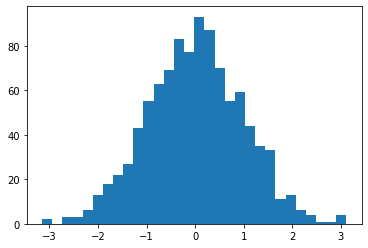

In [2]:
N = 1000
noise = np.random.randn(N)
plt.hist(noise, 30)
print(stats.kstest(noise, 'norm'))

The KS score is somewhat close to zero (but not quite zero) and the p-value is large, meaning that we cannot reject the hypothesis that the samples were drawn from the same distribution). Now let's try with a larger sample (N= 100,000 points).

KstestResult(statistic=0.0014640815275267505, pvalue=0.9828618168163874)


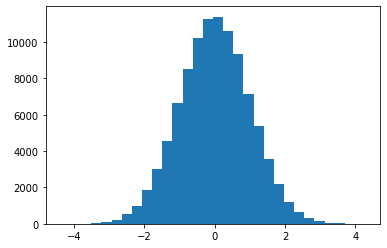

In [3]:
N = 100000
noise = np.random.randn(N)
plt.hist(noise, 30)
print(stats.kstest(noise, 'norm'))

For a non-Gaussian (uniform distribution) of random numbers we get:

KstestResult(statistic=0.5000000223908847, pvalue=0.0)


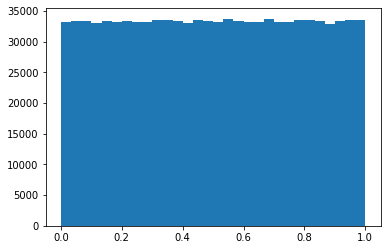

In [4]:
N = 1000000
noise = np.random.rand(N)
plt.hist(noise, 30)
print(stats.kstest(noise, 'norm', N=100000))

Now the KS statistics is high and the p-value is zero (meaning that we can reject the null hypothesis)

If we're comparing two data sets (e.g. $x$ and $y$),
we can use the function``ks_2samp``.  Again, Python outputs the actual statistics and the null hipothesys is that both datasets were drawn from the same distribution. Let's compare these two cases:

In [4]:
# Same distribution (normal)
N = 1000000
x = np.random.randn(N)
y = np.random.randn(N)
stats.ks_2samp(x, y)

Ks_2sampResult(statistic=0.0015169999999999906, pvalue=0.200058349113767)

In [5]:
# Different distributions (normal and uniform)
N = 1000000
x = np.random.randn(N)
y = np.random.rand(N)
stats.ks_2samp(x, y)

Ks_2sampResult(statistic=0.500229, pvalue=0.0)

The second was  a $\chi^2$ test, in which you bin your data into histograms
and ask if the number of data you find in each bin is consistent.

A second strategy is to bin the data and ask whether the number of
data in the bin is consistent with what we'd expect, using a $\chi^2$
statistics.  In this case for comparisons with a theoretical pdf,

$$\begin{equation}
\chi^2 = \sum_i\frac{(N_i-n_i)^2}{n_i},\hspace{3cm} (3)
\end{equation}$$

where $N_i$ is the observed number of events in bin $i$, and $n_i$ is the theoretical
or expected number of events in bin $i$.
For comparisons between two distributions,

$$\begin{equation}
\chi^2 = \sum_i\frac{(N_i-M_i)^2}{N_i+M_i},\hspace{3cm} (4)
\end{equation}$$

where $N_i$ and $M_i$ are each observed numbers of events for bin $i$.
The values of $\chi^2$ are evaluated using the $\chi^2$ probability function $Q(\chi^2|\nu)$, which is an incomplete gamma function,
where $\nu$ is the number of bins (or the number of bins minus one, depending on
normalization).  In Python this is:

``scipy.special.gammainc(nu/2, chi_squared/2)``

or equivalently

``scipy.stats.chi2.cdf(chi_squared, nu)``


In [24]:
import scipy.special as spe

In [9]:
bins = np.arange(-6, 6, 0.5)
a1, a2 = np.histogram(np.random.randn(N),bins);
b1, b2 = np.histogram(np.random.randn(N),bins);
c1, c2 = np.histogram(np.random.randn(N),bins);

In [26]:
chi2 = np.ma.sum(np.ma.masked_invalid((b1-a1)**2/(b1+a1)))
print('From chi2: ', stats.chi2.cdf(chi2, 25))
print('From gammainc: ', spe.gammainc(25/2, chi2/2))

From chi2:  0.09829775979238858
From gammainc:  0.09829775979238858


In [27]:
chi2 = np.ma.sum(np.ma.masked_invalid((c1-a1)**2/(c1+a1)))
print('From chi2: ', stats.chi2.cdf(chi2, 25))
print('From gammainc: ', spe.gammainc(25/2, chi2/2))

From chi2:  0.033173684126226635
From gammainc:  0.033173684126226635


If the data sets are similar at least at the 95\% level,
then we expect ``gammainc`` to return a value less than or equal to 0.95.

#### Fitting a function to data:  least-squares fitting

Now, let's return to our time series.  You might remember we were
looking for a linear trend for:

$$\begin{equation}
{\bf T}=T_o + b {\bf t} + {\bf n},\hspace{3cm} (5)
\end{equation}$$

where ${\bf T}$ represents our measured temperature data (as a vector),
$T_o$ is a constant (unknown), ${\bf t}$ is time, and $b$ is the time rate of
change (also unknown), and since this is the real world, ${\bf n}$ is noise
(representing the part of the signal that isn't a linear trend.
Formally, provided that we have more than two measurements, aside from
the unknown noise vector, this
is an over-determined system.
Since the noise is unknown, and there are lots of independent values,
the system is formally
underdetermined.  But we won't lose hope.  We just move forward under
the assumption that the noise is small.

Last time we started writing this as a matrix equation:

$$\begin{equation}
{\bf Ax} + {\bf n}= {\bf y},\hspace{3cm} (6)
\end{equation}$$

where

$$\begin{equation}
{\bf A} =  \left[\begin{array}{cc}
                              1 & t_1  \\
                              1 & t_2  \\
                              1 & t_3  \\
                              \vdots & \vdots \\
                              1 & t_N  \end{array}\right],\hspace{3cm} (7)
\end{equation}$$

making ${\bf A}$ an $N\times 2$ matrix.
And ${\bf y}$ is an $N$-element column vector containing, for example, our temperature data:
$$\begin{equation}
{\bf y} =  \left[\begin{array}{c}
                              T_1  \\
                              T_2  \\
                              T_3  \\
                              \vdots \\
                              T_N  \end{array}\right].\hspace{3cm} (8)
\end{equation}$$

Then ${\bf x}$ is the vector of unknown coefficients, in this case with
2 elements (e.g. $x_1=T_o$ and
$x_2=b$).

$$\begin{equation}
{\bf x} =  \left[\begin{array}{c}
                              x_1  \\
                              x_2 \end{array}\right] \hspace{3cm} (9)
\end{equation}$$

How can we find the best solution to this equation to minimize the misfit
between the data ${\bf y}$ and the model ${\bf Ax}$?   The
misfit could be positive or negative, and absolute values aren't mathematically
tractable, so let's start by squaring the misfit.

$$\begin{equation}
\epsilon = ({\bf Ax} - {\bf y})^T({\bf Ax} - {\bf y}) = {\bf x}^T{\bf A}^T{\bf Ax} - 2{\bf x}^T{\bf A}^T{\bf y} + {\bf y}^T{\bf y}.\hspace{3cm} (10)
\end{equation}$$

Then we can minimize the squared misfit.  The natural route to minimization
comes by taking the derivative, and then setting the results equal to
zero.  Our unknown is ${\bf x}$, so we'll minimize in terms of that:

$$\begin{equation}
\frac{\partial\epsilon}{\partial {\bf x}} = 2{\bf A}^T{\bf Ax} - 2{\bf A}^T{\bf y} = 0,\hspace{3cm} (11)
\end{equation}$$

and this implies that

$$\begin{equation}
 {\bf A}^T{\bf Ax} = {\bf A}^T{\bf y}, \hspace{3cm} (12)
\end{equation}$$

so

$$\begin{equation}
 {\bf x} = ({\bf A}^T{\bf A})^{-1}{\bf A}^T{\bf y}.\hspace{3cm} (13)
\end{equation}$$

In the exemple below we're gonna work with some fake data.

In [88]:
import xarray as xr

# Generate fake monthly SST data
time = np.arange(1, 12*10+1)
mean_temp = 16 
annual_cycle = 5*(np.sin(2 * np.pi * (time / 12)) + np.cos(2 * np.pi * (time / 12))) 
trend = 0.05*time
noise = 5*(np.random.rand(len(time)) - 0.5)
temperature = mean_temp + trend + annual_cycle + noise

Text(0.5, 0, 'months')

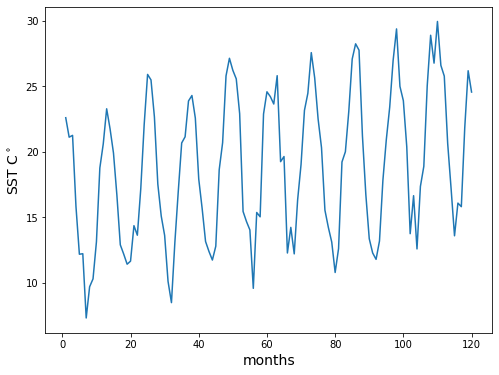

In [89]:
plt.figure(figsize=(8,6))
plt.plot(time, temperature)
plt.ylabel('SST C$^\\circ$', fontsize=14)
plt.xlabel('months', fontsize=14)

In [90]:
import numpy as np
from scipy.linalg import inv
nt = len(time)
A = np.array([np.ones(nt), time]).T
temperature = temperature.reshape([nt, 1])
x = np.dot(inv(np.dot(A.T, A)), np.dot(A.T, temperature))
fit = np.dot(A, x)

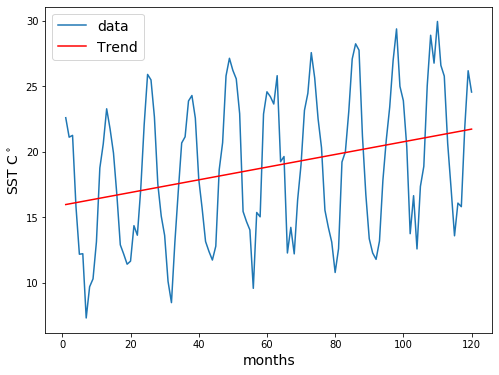

In [91]:
plt.figure(figsize=(8,6))
plt.plot(time, temperature, label = 'data')
plt.plot(time, fit, 'r', label = 'Trend')
plt.ylabel('SST C$^\\circ$', fontsize=14)
plt.xlabel('months', fontsize=14)
plt.legend(fontsize=14)

As we've noted, if we want to find a trend, we define ${\bf A}$ to have
a column of ones (to identify the mean) and a column containing the time,
to identify the rate of change.  We can make our model ${\bf A}$
progressively more complicated by adding additional columns.
What do we do if we want to find the
annual cycle?   Before I give you any answers, take a moment to think about
this.

We could use:
$$\begin{equation}
   {\bf A}= \left[\begin{array}{ccc}
                              1 & \cos(t_r) & \sin(t_r) \\
                              \vdots & \vdots & \vdots  \end{array}\right],\hspace{3cm} (14)
\end{equation}$$

where time $t$ is measured in days, and $t_r=2\pi t/365.25$, is the time in radians.
We need the sine and cosine because we don't know the phase of
our annual cycle exactly.  You might imagine that we could fit for the
phase (e.g. $\sin(t_r + \phi)$), and we could, but that would be a non-linear
fitting process, and the power of least-squares fitting won't work if we
try that---we'd quickly be plunged into the murky world of non-linear
fitting procedures, which is messy, unreliable, and not necessary in this case. Here's an example

In [93]:
A2 = np.array([np.ones(nt), time, np.sin(2*np.pi*time/12), np.cos(2*np.pi*time/12) ]).T 
x = np.dot(inv(np.dot(A2.T, A2)), np.dot(A2.T, temperature))
fit = np.dot(A2, x)

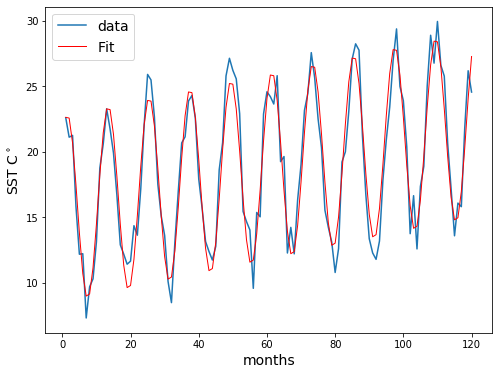

In [95]:
plt.figure(figsize=(8,6))
plt.plot(time, temperature, label = 'data')
plt.plot(time, fit, 'r', lw=1, label = 'Fit')
plt.ylabel('SST C$^\\circ$', fontsize=14)
plt.xlabel('months', fontsize=14)
plt.legend(fontsize=14)

#### Orthogonality and Least-Squares Fits

Let's think about one important detail of our fitting procedure.
What would happen if we wanted to fit $T=x_1 + x_2 t_r + x_3 t_r$, that
is to fit two constants to the same variable?  In this case, clearly $x_2$
and $x_3$ are completely indistinguishable.
What happens when we try to use our redundant functions in our matrix ${\bf A}$?
$$\begin{equation}
{\bf A}=\left[\begin{array}{ccc} 1 & t_1 & t_1 \\
                           1 & t_2 & t_2 \\
                           \vdots & \vdots & \vdots \\
                           1 & t_N & t_N \end{array}\right].\hspace{3cm} (15)
\end{equation}$$

Then we find:

$$\begin{equation}
{\bf A}^T{\bf A} = \left[\begin{array}{ccc} N & \sum t_i & \sum t_i \\
                               \sum t_i & \sum t_i^2 & \sum t_i^2 \\
                               \sum t_i & \sum t_i^2 & \sum t_i^2
        \end{array}\right].\hspace{3cm} (16)
\end{equation}$$

The second and third rows of ${\bf A}^T{\bf A}$ are identical, which tells us that
the third row is adding no additional information to the system.  As a
result, the matrix ${\bf A}^T{\bf A}$ is singular, and we won't be able to find an
inverse for it.

You probably wouldn't try to
fit coefficients to two identical functions, but you might do something that
was fairly similar.
For example, $T=x_2 t_r + x_3 \sin(t_r)$ poses a similar problem when $t_r$ is
near zero.  In this case, the rows of ${\bf A}^T{\bf A}$ might not be identical, but
they might be nearly the same so that Matlab would give you an error
message.

Similarly, you'll have trouble if you try:  $T=x_1 +x_2 t_r + x_3 (1+t_r)$.

None of this was an issue when we used  sine and cosine, because
they are orthogonal, so they contain no redundant information.

##### Building complexity:  multiple oscillatory signals

Now let's think about the pressure record from the Scripps pier, because
we know that had a lot of sinusoidal variability.  What might we include
in that fit?  We might hypothesize that data collected on the pier
could be influenced by an annual cycle (1 cycle/365.25 days), a diurnal
cycle (1 cycle/24 hours), and a tidal cycle (1 cycle/0.5175 days =
1 cycle/(12 hours + 25.2 minutes)).  How would we fit for all of these
components?

#### Questions about pier data

Here are some questions (yours plus some stray questions):

1. How do temperature and salinity vary seasonally, annually, interannually, and on decadal time scales?  What accuracies do we need to assess these modes of variability?
2. How have changes in the location of the pier influenced the long-term record?  What is the stability of the instrumentation?  Do error bars evolve over time?
3. Does the pier create noise/flow distortion?
4. How well do the manual and automated records match?
5. Who quality controls the data, and how?
6. Is there visibility data?
7. Which of the variables associated with the pier record are measured directly, and which are inferred?
8. What methods have been used to collect measurements on the pier, and how consistent are they? 
9. What variables are collected?  What is the formal uncertainty? What is the sampling frequency?
10. When did automated sampling start?  When did automated sampling start being reliable?
11. What are purposes of automated vs manual systems?}
12. What level of adjustment is applied to make manual and automated data match?
13. What has been published about these data?
14. How often are the sensors serviced?
15. What accounts for gaps in the data?
16. How hands on is the automated system?  What's really automatized?
17. What depths are the sensors?
18. Where are the sensors?
19. Are multiple sensors used are merged?
20. What is the local geographic variability?
21. What is the time of day of measurement?  How clearly is that documented?
22. What does instrument failure look like in the data records?
23. What error flags are available for the data?
24. How long are records?
25. How is equipment calibrated?  And how often?